<a href="https://colab.research.google.com/github/fneaplle/ML/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
import session
'''

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/PL/Data/100average_interpol.csv'

df = pd.read_csv(path, index_col='Datetime', parse_dates=True, encoding='cp949')
df = df[:30000]

df['time'] = df.index
df.reset_index(inplace=True, drop=True)

date_time = df['time']
df = df.drop(['time'], axis=1)
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [5]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

#Data Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

In [6]:
input_length=7*24 #168
target_length=1*24 #24
num_features=5
BATCH_SIZE=32

In [7]:
def batch_generator(data, input_width, label_width, shift, label_columns):
    batch_size=32
    x_num_signal=num_features
    y_num_signal=len(label_columns)
    
    ds=data
    label_ds=data[label_columns].values
    
    total_data_size=len(ds)
    total_window_size=input_width+shift
    
    input_slice=slice(0,input_width)
    input_indices=np.arange(total_window_size)[input_slice]
    
    label_slice=slice(total_window_size-label_width, None)
    label_indices=np.arange(total_window_size)[label_slice]

    iter1=(total_data_size-total_window_size)//batch_size
    for i in range(iter1):
        x_shape=(batch_size, len(input_indices), x_num_signal)
        x_batch=np.zeros(shape=x_shape, dtype=np.float64)

        y_shape=(batch_size, len(label_indices), y_num_signal)
        y_batch=np.zeros(shape=y_shape, dtype=np.float64)
        for j in range(batch_size):
            start=i*batch_size+j
            end=start+total_window_size
            x_batch[j]=ds[slice(start, start+input_width)]
            y_batch[j]=label_ds[slice(end-label_width, end)]
            
        yield x_batch, y_batch

In [8]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1=tf.keras.layers.Dense(32, activation='relu')
        self.layer2=tf.keras.layers.Dense(64, activation='relu')
        self.flatten=tf.keras.layers.Flatten()
        self.layer3=tf.keras.layers.Dense(num_features*target_length, activation='relu',
                                          kernel_initializer=tf.initializers.zeros)
        self.reshape=tf.keras.layers.Reshape((target_length, num_features))
        
    def call(self, x):        
      x=self.layer1(x)
      x=self.layer2(x)
      x=self.flatten(x)
      x=self.layer3(x)
      x=self.reshape(x)
      return x
    
model=MLP()

In [12]:
loss_object=tf.keras.losses.MSE
acc_object=tf.keras.losses.MAE
rmse_object=tf.keras.metrics.RootMeanSquaredError()
mse_object=tf.keras.metrics.MeanSquaredError()
msle_object=tf.keras.metrics.MeanSquaredLogarithmicError()
mape_object=tf.keras.metrics.MeanAbsolutePercentageError()

train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy=tf.keras.metrics.Mean(name='train_accuracy')
test_mape=tf.keras.metrics.Mean(name='test_mape')
val_loss=tf.keras.metrics.Mean(name='val_loss')

In [9]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object=tf.keras.losses.MSE
train_metric=tf.keras.metrics.MAE

In [17]:
def quantile_loss(y, y_pred, quantile):
  '''
  Args:
  y_pred: pred
  y: true
  '''

  if quantile<0 or quantile >1:
    raise ValueError('Illegal quantile value={}! Values should be between 0 and 1.'.format(quantile))

  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

In [13]:
#batch_generator(data, input_width, label_width, shift, label_columns):
train_loss_list=[]
val_loss_list=[]

num_epochs = 10

for epoch in range(num_epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    
    print(f'epoch:{epoch}')
    for inp, tar in batch_generator(train_df, 168, 24, 24, train_df.columns):        
        with tf.GradientTape() as t:
            pred=model(inp)
            loss_value=loss_object(y_true=tar, y_pred=pred)
            
        grads=t.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        acc_value=acc_object(pred, tar)
        
        train_loss(loss_value)
        train_accuracy(acc_value)

    train_loss_list.append(train_loss.result().numpy())
    
    for inp_val, tar_val in batch_generator(val_df, 168, 24, 24, val_df.columns):
        pred_val=model(inp)
        loss_value_val=loss_object(pred_val, tar_val)
        val_loss(loss_value_val)
    
    val_loss_list.append(val_loss.result().numpy())
    
    print(f'train_loss:{train_loss.result().numpy()}, train_accuracy:{train_accuracy.result().numpy()}')
    print(f'validation_loss:{val_loss.result().numpy()}')

epoch:0
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:1
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:2
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:3
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:4
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:5
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:6
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:7
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:8
train_loss:1.0019605159759521, train_accuracy:0.7508313655853271
validation_loss:3.552854537963867
epoch:9
train_loss:1.0019605159759521

In [ ]:
#save model
model.save_weights('./DNN-normal.ckpt')

In [ ]:
#load model
model.load_weights('./DNN-normal.ckpt')

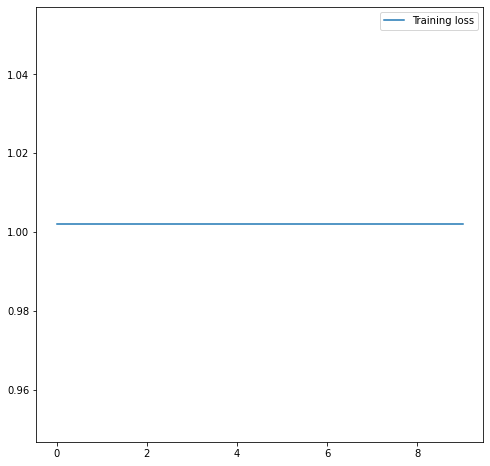

In [15]:
#train, validation loss graph
plt.figure(figsize=(8,8))
plt.plot(range(num_epochs), train_loss_list, label='Training loss')
#plt.plot(range(num_epochs), val_loss_list, label='Validation loss') 
plt.legend(loc='upper right')

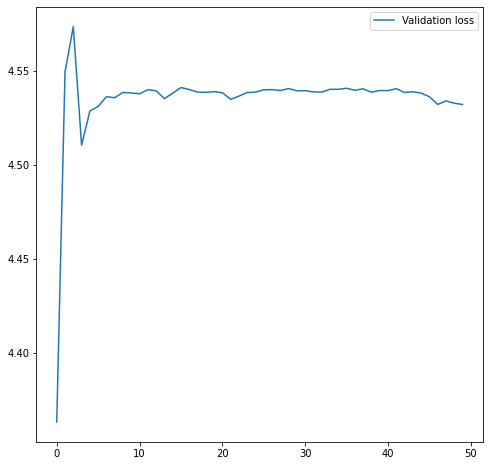

In [ ]:
#validation loss graph
plt.figure(figsize=(8,8))
#plt.plot(range(num_epochs)[10:], train_loss_list[10:], label='Training loss')
plt.plot(range(num_epochs), val_loss_list, label='Validation loss')
plt.legend(loc='upper right')

In [20]:
quantile_metrics=tf.keras.metrics.Mean()

In [21]:
#Model Performance
#MSE/RMSE/MSLE/R2/MAPE
from sklearn.metrics import r2_score

mean=train_mean['FRWR_ACT_QTY']
std=mean=train_std['FRWR_ACT_QTY']

r2=tf.metrics.Mean()
r2.reset_states()
rmse_object.reset_states()
mse_object.reset_states()
msle_object.reset_states()
mape_object.reset_states()

for inp, tar in batch_generator(test_df, 168, 24, 24, test_df.columns):
    pred=model(inp)[:,:,0]
    tar=tar[:,:,0]
    
    #r2(r2_score(y_true=tar, y_pred=pred, multioutput='variance_weighted'))
    rmse_object(y_true=tar, y_pred=pred)
    mse_object(y_true=tar, y_pred=pred)
    msle_object(y_true=tar, y_pred=pred)
    mape_object(y_true=tar, y_pred=pred)
    quantile_metrics(quantile_loss(tar,pred, 0.5))
    
    #print(f'quantile_loss : {quantile_loss(tar,pred,0.5)}')

#print(f'Model R2: {r2.result().numpy()}')
print(f'Model RMSE: {rmse_object.result().numpy()}')
print(f'Model MSE: {mse_object.result().numpy()}')
print(f'Model MSLE: {msle_object.result().numpy()}')
print(f'Model Quantile(0.5): {quantile_metrics.result().numpy()}')
print(f'Model MAPE: {mape_object.result().numpy()}%')



Model RMSE: 4.561751842498779
Model MSE: 20.809589385986328
Model MSLE: 0.05295954644680023
Model Quantile(0.5): 4.081040382385254
Model MAPE: 100.0%


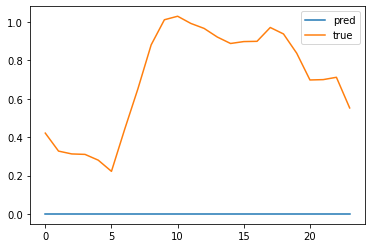

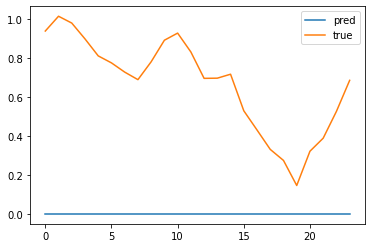

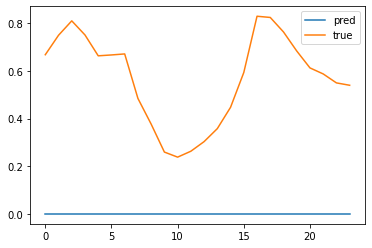

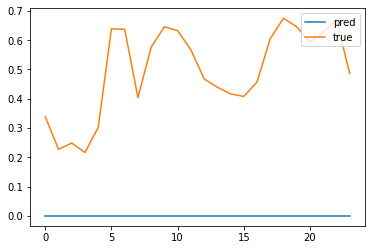

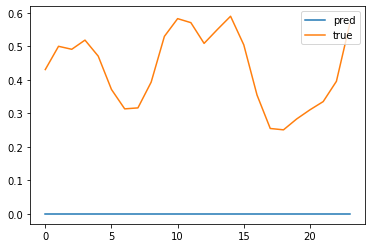

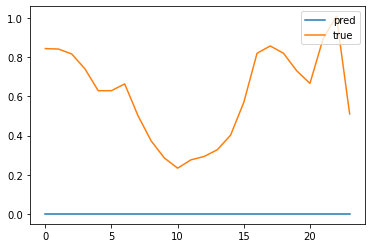

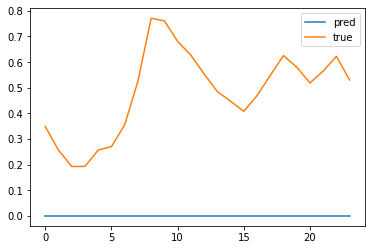

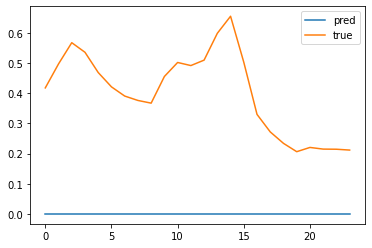

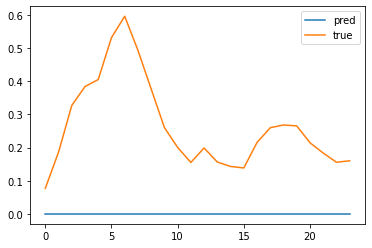

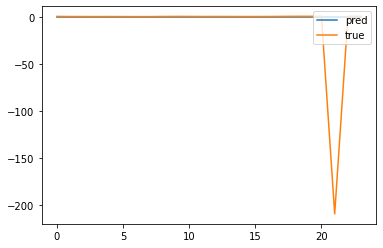

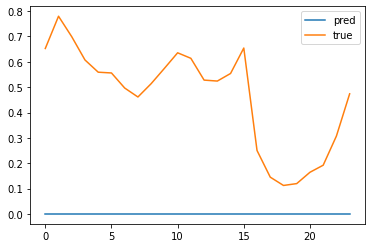

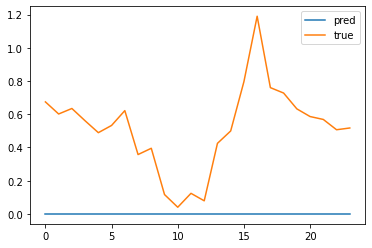

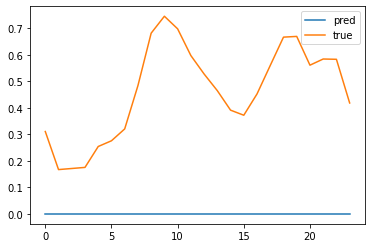

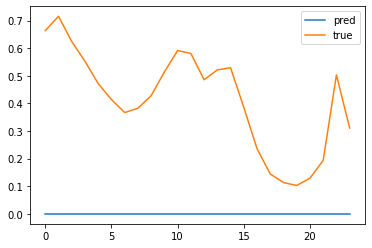

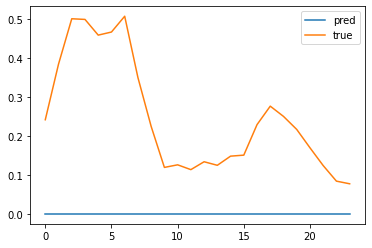

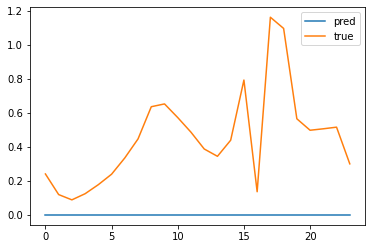

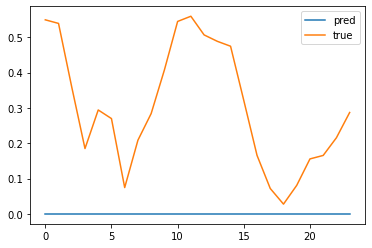

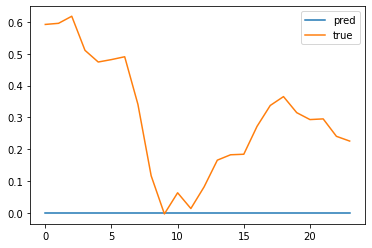

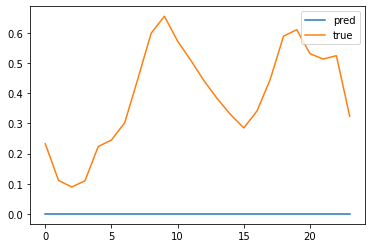

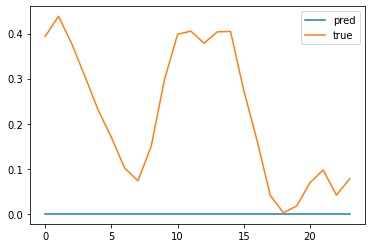

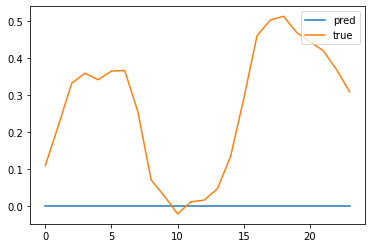

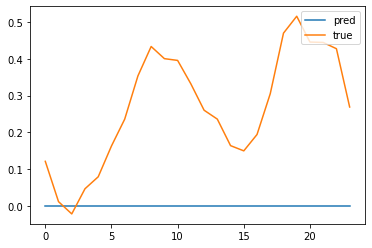

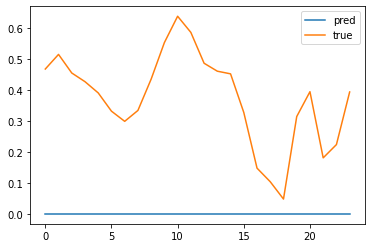

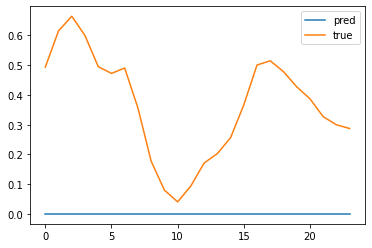

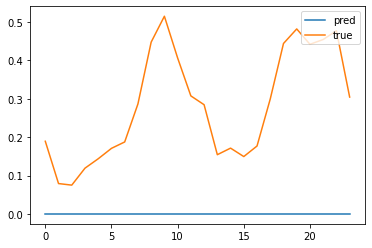

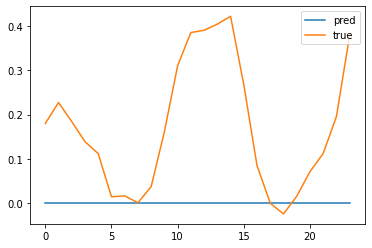

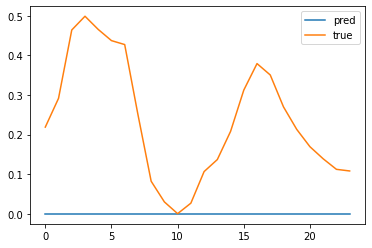

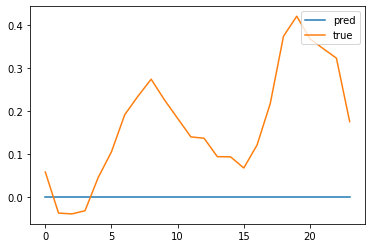

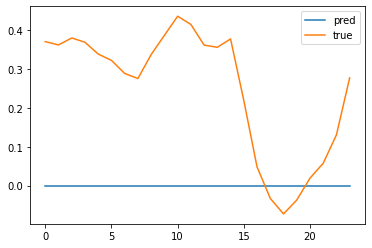

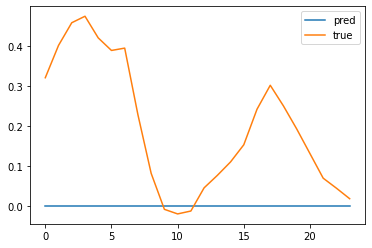

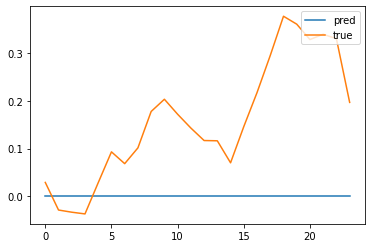

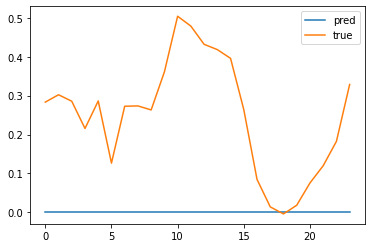

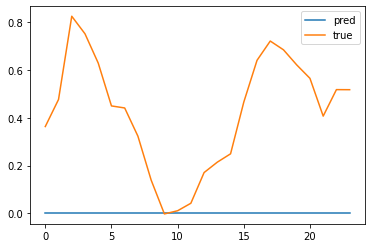

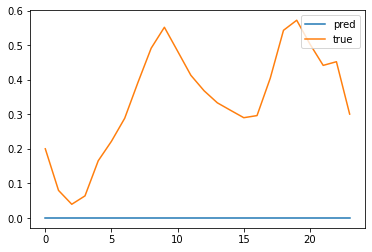

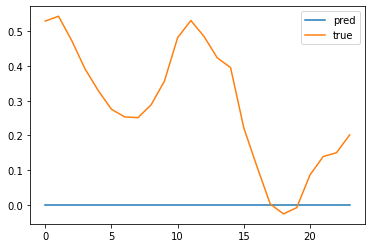

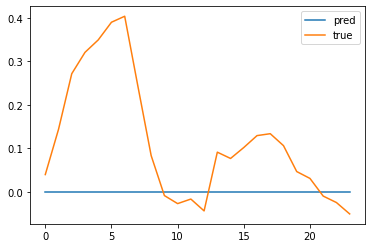

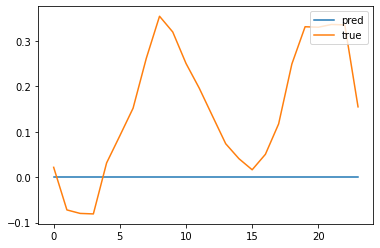

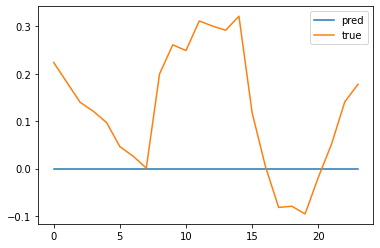

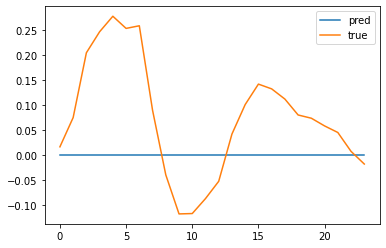

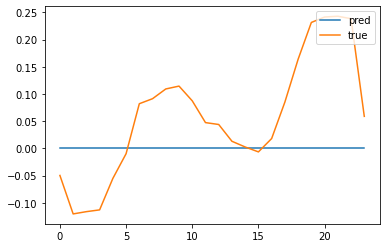

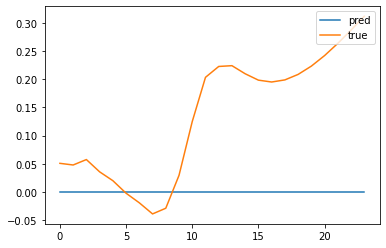

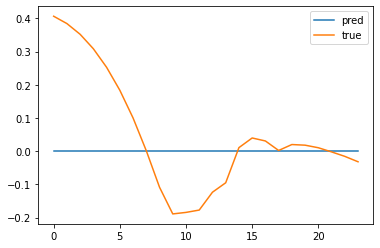

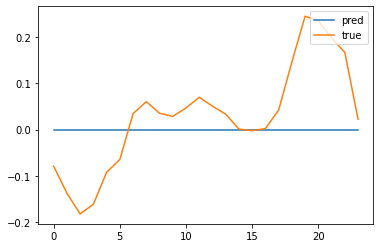

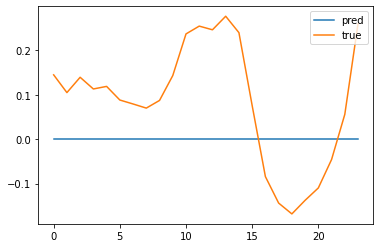

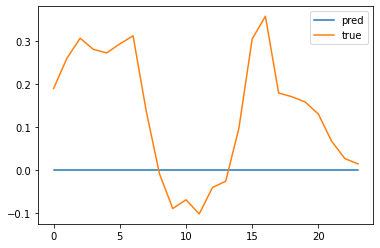

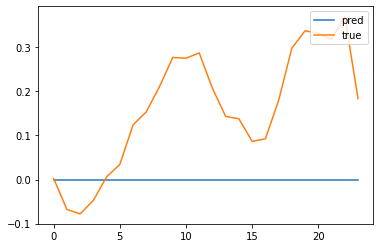

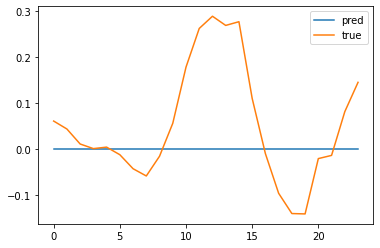

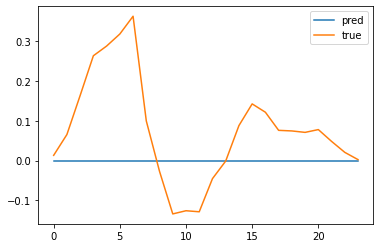

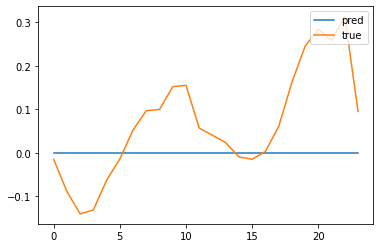

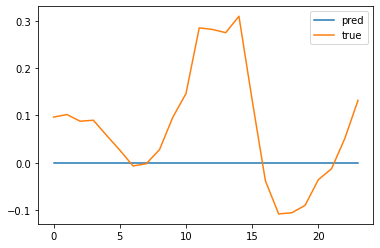

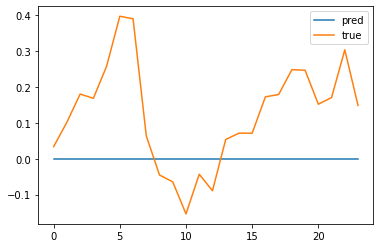

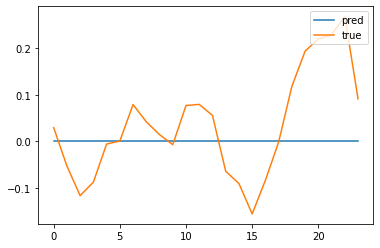

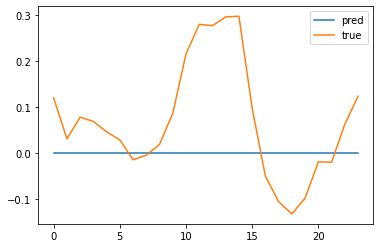

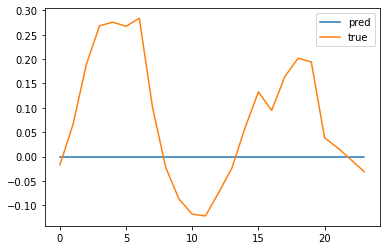

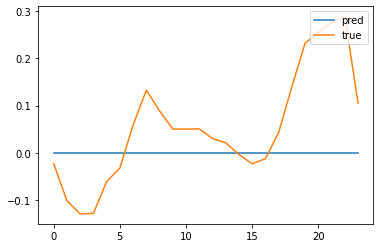

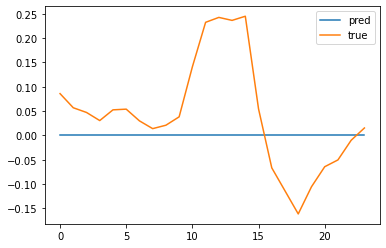

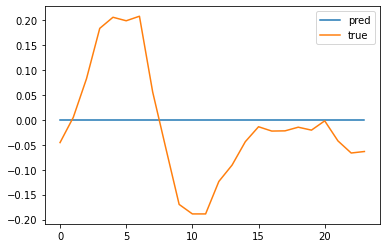

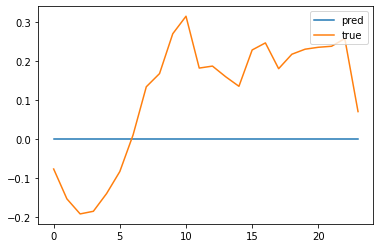

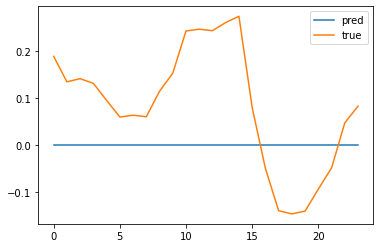

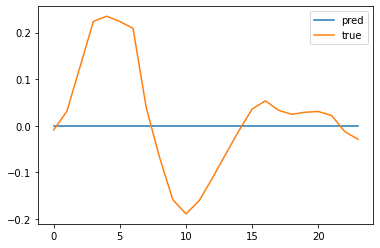

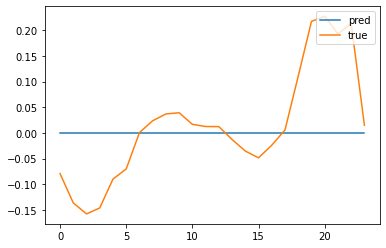

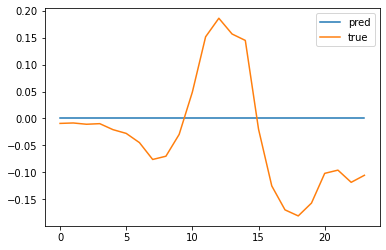

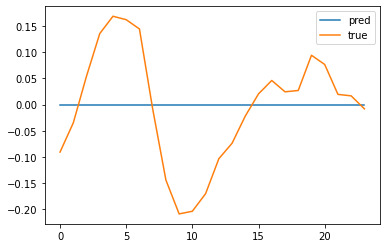

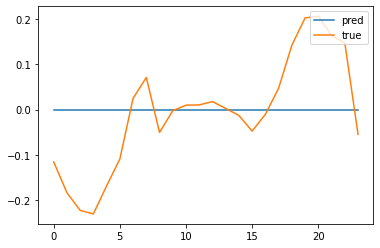

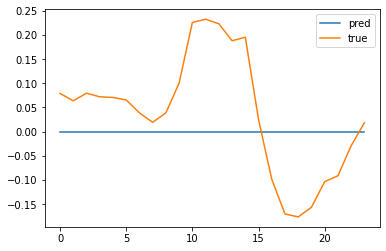

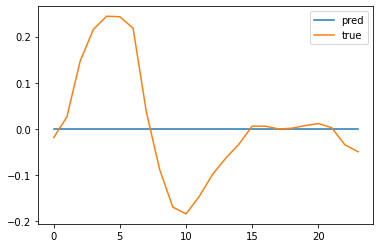

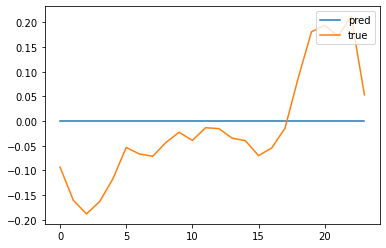

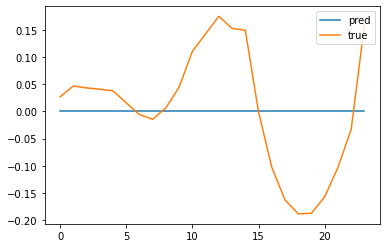

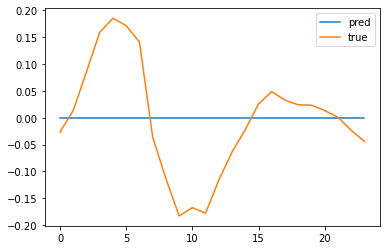

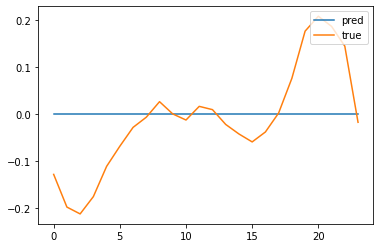

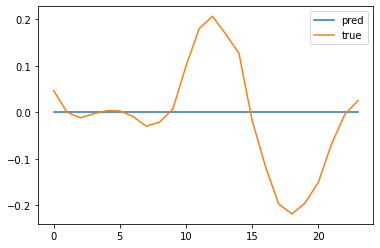

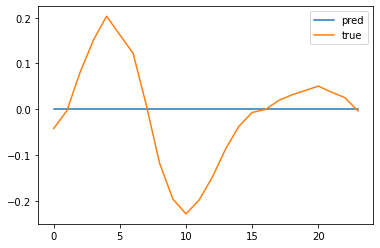

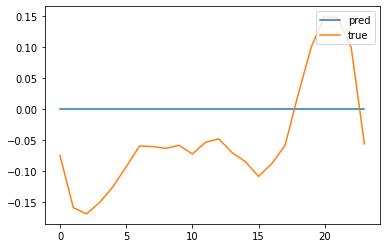

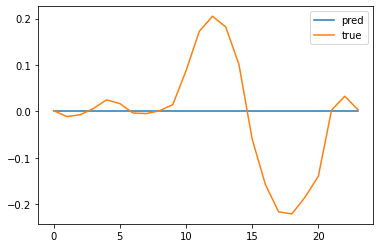

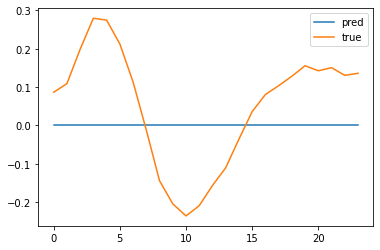

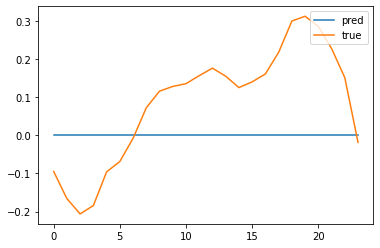

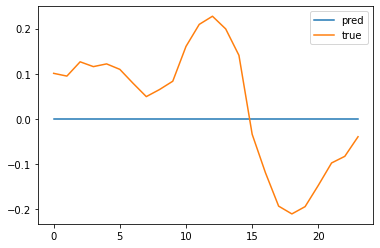

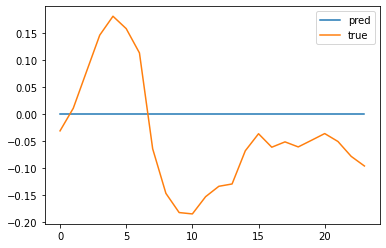

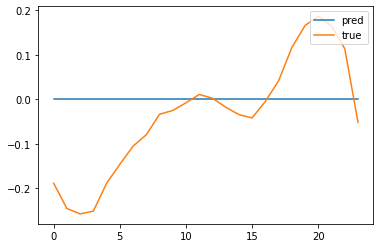

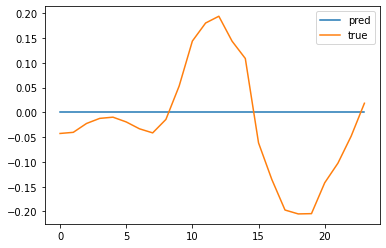

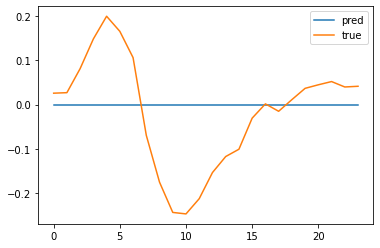

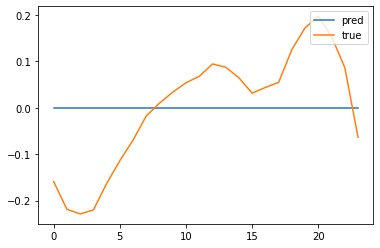

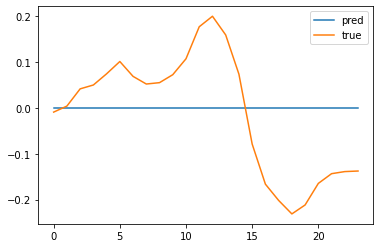

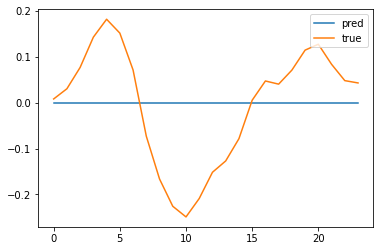

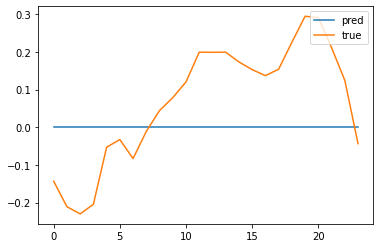

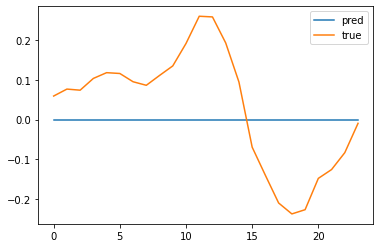

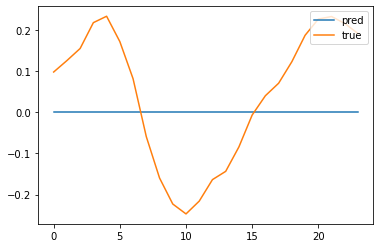

In [46]:
#Plotting

for inp, tar in batch_generator(test_df, 168, 24, 24, test_df.columns):
    pred=model(inp)
    
    plt.plot(range(24), pred[1][:,0], label='pred')
    plt.plot(range(24), tar[1][:,0], label='true')
    plt.legend(loc='upper right')
    plt.show()